In [2]:
import graph_tool.all as gt
import numpy as npr
import numpy.random as npr
from numpy.linalg import norm
from pylab import *
import os
from datetime import datetime

In [3]:
                                       #importing data

mass, lum, mag= loadtxt('new_data.txt', usecols=(2,3,4), unpack=True, skiprows=2)



                                     #building the graph

g = gt.Graph(directed=False)
Mass = g.new_vertex_property('float')
Lum  = g.new_vertex_property('float')
Mag = g.new_vertex_property('float')
pos = g.new_vertex_property('vector<float>')
pos_ = g.new_vertex_property('vector<float>')


In [4]:
g.vp.mass=Mass
g.vp.lum = Lum
g.vp.mag = Mag
g.vp.pos = pos
g.vp.pos_ = pos_

In [5]:
                                      #global parameters

N=800


mag =mag[0:N]
lum =lum[0:N]
mass =mass[0:N]

init_foot = 0.003
ibin =      0.003
fbin =      0.21

max_iter=8
init_step=0.5
K=1.5

In [13]:
np.array([[min(mag), max(mag)],
[min(lum), max(lum)],
[min(mass), max(mass)]])

array([[ 3.589477,  4.862083],
       [ 5.343182,  6.001361],
       [12.495226, 59.949995]])

In [14]:
#minmax scaling
mag -= min(mag); mag /= max(mag)

lum -= min(lum); lum /= max(lum)

mass -= min(mass); mass /= max(mass)

In [15]:
np.array([[min(mag), max(mag)],
[min(lum), max(lum)],
[min(mass), max(mass)]])

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

In [41]:
                                       #applying properties


v = g.add_vertex(N)

for i, v in enumerate(g.vertices()):
    g.vp.mass[v]=mass[i]
    g.vp.lum[v]=lum[i]
    g.vp.mag[v]=mag[i]
    g.vp.pos[v] = np.array([mag[i],lum[i]]).T


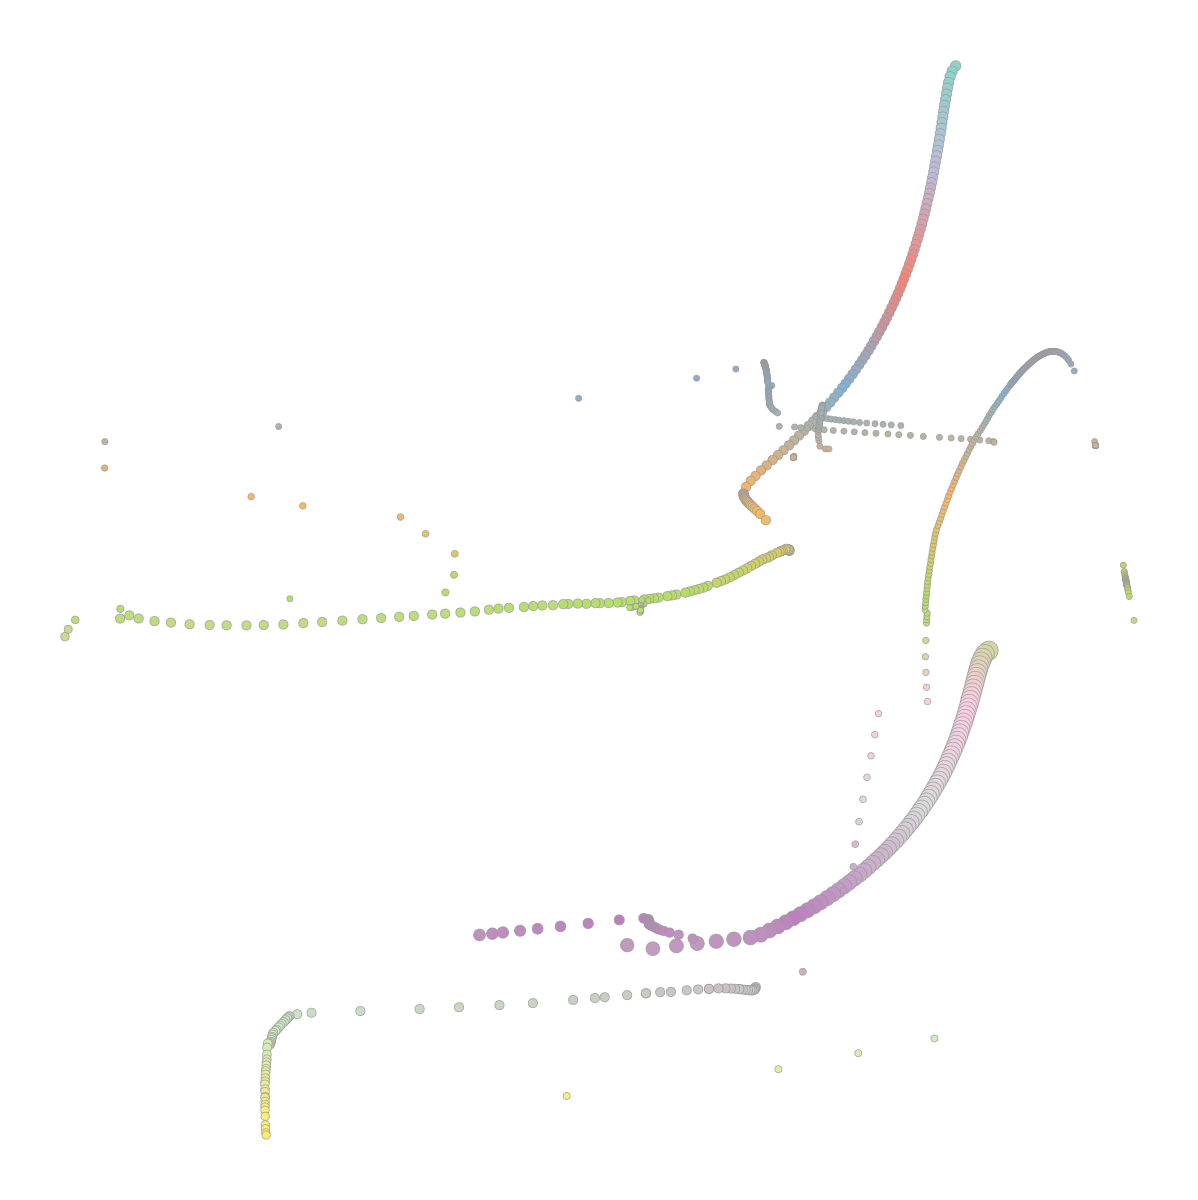

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f41ba484e50, at 0x7f41ba4661c0>

In [42]:
gt.graph_draw(g, pos=g.vp.pos, vertex_fill_color=g.vp.lum,vertex_size=gt.prop_to_size(g.vp.mass, mi=3, ma=9.5, log=False, power=2))

In [43]:
posv=g.vp.pos.get_2d_array([0, 1]).T

In [44]:
gg, gpos = gt.geometric_graph(posv, ibin)

In [45]:
gu = gt.graph_union(gg, g, intersection=g.vertex_index, internal_props=True)

In [46]:
gu.copy_property(gpos, tgt=gu.vp.pos_, g=gg)

In [47]:
gu.vp.pos_ = gt.sfdp_layout(gu, pos=gu.vp.pos_, K=K)

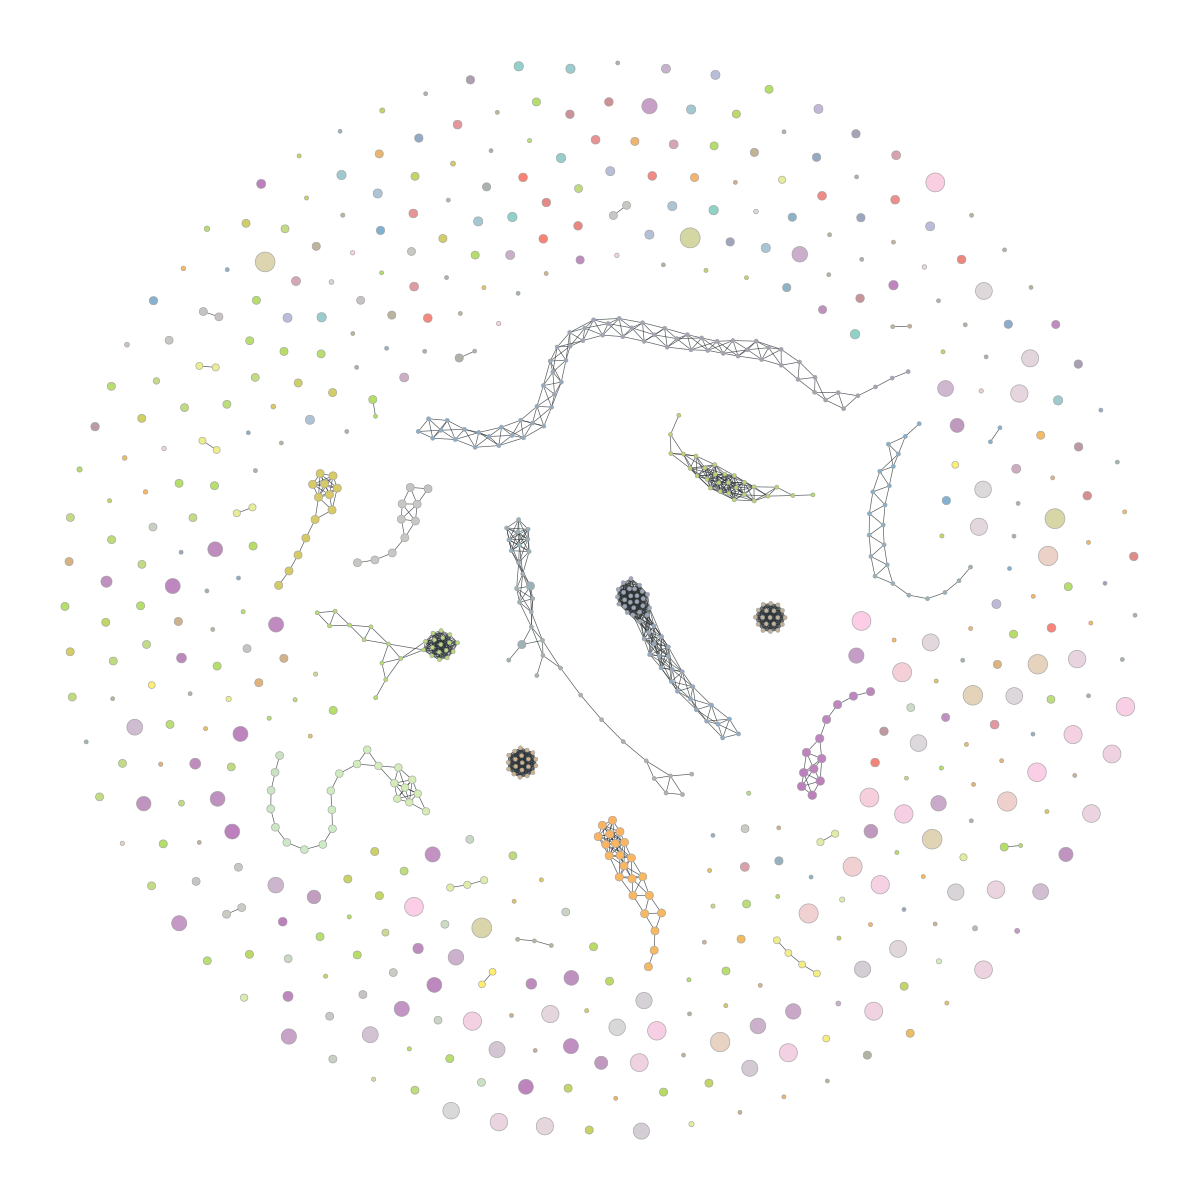

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f41b9b2a280, at 0x7f41ba5c1bb0>

In [48]:
gt.graph_draw(gu, pos=gu.vp.pos_, vertex_fill_color=gu.vp.lum,vertex_size=gt.prop_to_size(gu.vp.mass, mi=2, ma=10, log=False, power=2))

In [55]:
def graph_sequence(g, ibin, init_foot, fbin, init_step, max_iter, K):
    cbin = ibin
    g.vp.pos_ = gt.sfdp_layout(g, pos=g.vp.pos_, K=K)
    graphs = [g.copy()]
    points = g.vp.pos.get_2d_array([0,1]).T
    while cbin <= fbin:

        cbin+=init_foot
        gg, gpos = gt.geometric_graph(points, cbin)
        
        gu= graphs[-1].copy()
        gu = gt.graph_union(gg, gu, intersection=gu.vertex_index, internal_props=True)
        
        gu.set_fast_edge_removal()
        gt.remove_parallel_edges(gu)
        gu.vp.pos_ = gt.sfdp_layout(gu, pos=gu.vp.pos_, max_iter=max_iter, init_step=init_step, K=K)
        graphs.append(gu)
        
    return graphs


In [ ]:
def draw_frames(glist):
    stamp = datetime.strftime(datetime.now(), "%d_%h-%H-%M")
    outpath = f"./outputs_{stamp}"
    if not os.path.exists(outpath):
        os.mkdir(outpath)
    for i, gu in enumerate(glist):
        gt.graph_draw(
            gu,
            pos=gu.vp.pos_,
            vertex_fill_color=gu.vp.lum,
            edge_pen_width=0.2,
            vertex_size=gt.prop_to_size(gu.vp.mass, mi=2, ma=10, log=False, power=2),
            output=os.path.join(outpath, "frame%06d.png" % i),
        )


In [57]:
%%timeit -n 1 -r 1
graph_sequence(gu, ibin, init_foot, fbin, init_step, max_iter, K);

8.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [60]:
graphlist = graph_sequence(gu, ibin, init_foot, fbin, init_step, max_iter, K);

In [65]:
draw_frames(graphlist)

KeyboardInterrupt: 